# DWPP Real Result Analysis

## Import

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import math
from pathlib import Path
import os
from collections import defaultdict
import analysis_lib as al

path_list = ["PathA", "PathB", "PathC"]
controller_list = ["PP", "APP", "RPP", "DWPP"]
PathA, PathB, PathC = al.make_path()
reference_path = {
    "PathA": PathA,
    "PathB": PathB,
    "PathC": PathC
}

## Calc quantitative data

In [80]:
path_dir = Path("/home/decwest/decwest_workspace/dwpp_test_simulation/data/real_robot_experiment")
all_data_dict = defaultdict(lambda: defaultdict(list))

for path_name in path_list:
    for controller_name in controller_list:
        data_path = path_dir / path_name / controller_name
        # each data
        for file_path in data_path.glob("*.csv"):
            # read csv
            df = pd.read_csv(file_path)
            data_dir = file_path.parent
            
            # Extract relevant data
            timestamp = df["sec"].to_numpy() + df["nsec"].to_numpy() * 1e-9
            timestamp -= timestamp[0]  # Normalize to start from zero
            curvature = df["curvature"].to_numpy()
            v_now = df["v_now"].to_numpy()
            w_now = df["w_now"].to_numpy()
            v_cmd = df["v_cmd"].to_numpy()
            w_cmd = df["w_cmd"].to_numpy()
            actual_v = df["v_nav"].to_numpy()
            actual_w = df["w_nav"].to_numpy()
            v_real = df["v_real"].to_numpy()
            w_real = df["w_real"].to_numpy()
            dw_max_v = df["dw_v_max"].to_numpy()
            dw_max_w = df["dw_w_max"].to_numpy()
            dw_min_v = df["dw_v_min"].to_numpy()
            dw_min_w = df["dw_w_min"].to_numpy()
            v_reg = df["v_reg"].to_numpy()
            
            map_base_x = df["map_base_x"].to_numpy()
            map_base_y = df["map_base_y"].to_numpy()
            map_base_yaw = df["map_base_yaw"].to_numpy()
            velocity_violation = df["velocity_violation"].to_numpy()
            
            x, y, yaw = al.transform_pose_to_path_origin(map_base_x, map_base_y, map_base_yaw, map_base_x[0], map_base_y[0], map_base_yaw[0])
            
            # calc velocity violation ratio
            violation_rate = al.calc_violation_rate(velocity_violation)
            
            # calc tracking error
            path = al.reference_path[path_name]
            robot_path = np.vstack((x, y)).T
            tracking_errors = al.calc_tracking_error(robot_path, path)
            
            # calc travel time
            travel_time = al.measure_travel_time(timestamp)
            
            # prepare data storage
            data_dict = {"x": x, "y": y,
                         "violation_rate": violation_rate,
                         "tracking_errors": tracking_errors,
                         "travel_time": travel_time}
            
            all_data_dict[path_name][controller_name].append(data_dict)
            

- velocity violation
  - mean and std of five times
- tracking error
  - mean and std of all tracking errors, max of five times
- travel time
  - mean and std

In [81]:
def calc_mean_and_std(values, ddof=0):
    values = np.asarray(values)
    return values.mean(), values.std(ddof=ddof)

records = []

for path_name in path_list:
    
    for controller_name in controller_list:
        data_list = all_data_dict[path_name][controller_name]

        velocity_violations = [d["violation_rate"] for d in data_list]
        tracking_errors_per_trial = [d["tracking_errors"] for d in data_list]
        travel_times = [d["travel_time"] for d in data_list]

        # flatten tracking errors over all trials
        all_tracking_errors = []
        for errors in tracking_errors_per_trial:
            all_tracking_errors.extend(errors.tolist())

        velocity_violations_mean, velocity_violations_std = \
            calc_mean_and_std(velocity_violations)

        all_tracking_errors_mean, all_tracking_errors_std = \
            calc_mean_and_std(all_tracking_errors)

        max_tracking_errors = [errors.max() for errors in tracking_errors_per_trial]
        max_tracking_errors_mean, max_tracking_errors_std = \
            calc_mean_and_std(max_tracking_errors)

        travel_times_mean, travel_times_std = \
            calc_mean_and_std(travel_times)
        if controller_name == "DWPP" and path_name == "PathC":
            print("Debug DWPP PathC travel times:", travel_times)
        data_dict = {"path": path_name, "controller": controller_name, \
            "velocity_violation_mean": velocity_violations_mean,
            "velocity_violation_std": velocity_violations_std,
            "all_tracking_errors_mean": all_tracking_errors_mean,
            "all_tracking_errors_std": all_tracking_errors_std,
            "max_tracking_errors_mean": max_tracking_errors_mean,
            "max_tracking_errors_std": max_tracking_errors_std,
            "travel_time_mean": travel_times_mean,
            "travel_time_std": travel_times_std}
        records.append(data_dict)



Debug DWPP PathC travel times: [25.999682664871216, 26.16614603996277, 27.266417741775513, 26.63280463218689, 24.59981608390808]


In [82]:
df = pd.DataFrame(records)

In [83]:
velocity_violation_mean_table = df.pivot(
    index="path",
    columns="controller",
    values="velocity_violation_mean"
)
velocity_violations_std_table = df.pivot(
    index="path",
    columns="controller",
    values="velocity_violation_std"
)
all_tracking_errors_mean_table = df.pivot(
    index="path",
    columns="controller",
    values="all_tracking_errors_mean"
)
all_tracking_errors_std_table = df.pivot(
    index="path",
    columns="controller",
    values="all_tracking_errors_std"
)
max_tracking_errors_mean_table = df.pivot(
    index="path",
    columns="controller",
    values="max_tracking_errors_mean"
)
max_tracking_errors_std_table = df.pivot(
    index="path",
    columns="controller",
    values="max_tracking_errors_std"
)
travel_time_mean_table = df.pivot(
    index="path",
    columns="controller",
    values="travel_time_mean"
)
travel_time_std_table = df.pivot(
    index="path",
    columns="controller",
    values="travel_time_std"
)

velocity_violation_mean_table = velocity_violation_mean_table.reindex(columns=controller_list)
velocity_violations_std_table = velocity_violations_std_table.reindex(columns=controller_list)
all_tracking_errors_mean_table = all_tracking_errors_mean_table.reindex(columns=controller_list)
all_tracking_errors_std_table = all_tracking_errors_std_table.reindex(columns=controller_list)
max_tracking_errors_mean_table = max_tracking_errors_mean_table.reindex(columns=controller_list)
max_tracking_errors_std_table = max_tracking_errors_std_table.reindex(columns=controller_list)
travel_time_mean_table = travel_time_mean_table.reindex(columns=controller_list)
travel_time_std_table = travel_time_std_table.reindex(columns=controller_list)

# to csv
velocity_violation_mean_table.to_csv("/home/decwest/decwest_workspace/dwpp_test_simulation/data/real_robot_experiment/velocity_violation_mean_table.csv")
velocity_violations_std_table.to_csv("/home/decwest/decwest_workspace/dwpp_test_simulation/data/real_robot_experiment/velocity_violation_std_table.csv")
max_tracking_errors_mean_table.to_csv("/home/decwest/decwest_workspace/dwpp_test_simulation/data/real_robot_experiment/max_tracking_errors_mean_table.csv")
max_tracking_errors_std_table.to_csv("/home/decwest/decwest_workspace/dwpp_test_simulation/data/real_robot_experiment/max_tracking_errors_std_table.csv")
all_tracking_errors_mean_table.to_csv("/home/decwest/decwest_workspace/dwpp_test_simulation/data/real_robot_experiment/all_tracking_errors_mean_table.csv")
all_tracking_errors_std_table.to_csv("/home/decwest/decwest_workspace/dwpp_test_simulation/data/real_robot_experiment/all_tracking_errors_std_table.csv")
travel_time_mean_table.to_csv("/home/decwest/decwest_workspace/dwpp_test_simulation/data/real_robot_experiment/travel_time_mean_table.csv")
travel_time_std_table.to_csv("/home/decwest/decwest_workspace/dwpp_test_simulation/data/real_robot_experiment/travel_time_std_table.csv")

## Plot Path and velocity Profile

### Plot Path

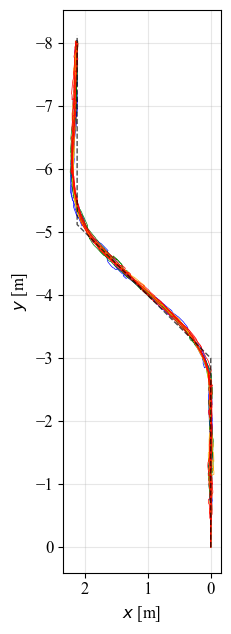

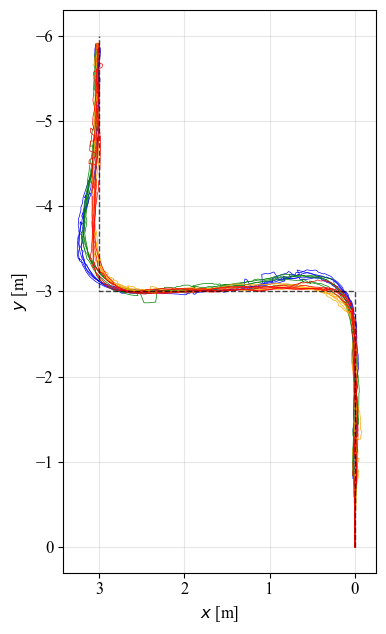

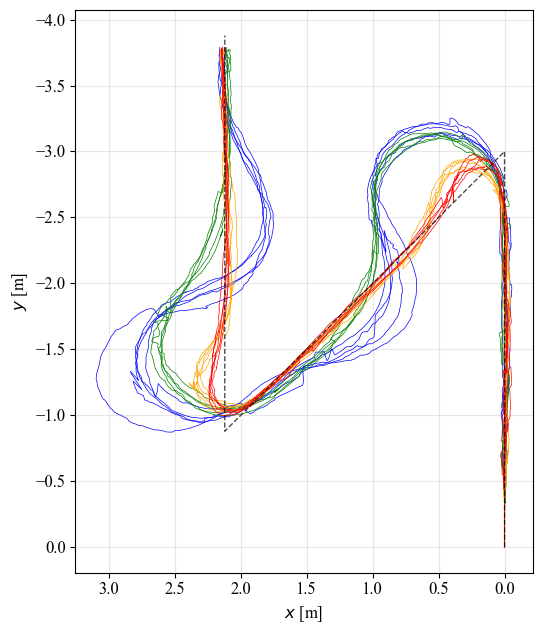

In [84]:
color_dict = {"PP": "blue", "APP": "green", "RPP": "orange", "DWPP": "red"}


for path_name in path_list:
    fig = plt.figure(figsize=(6.5,6.5))
    ax = fig.add_subplot(1, 1, 1)
    
    for controller_name in controller_list:
        data_list = all_data_dict[path_name][controller_name]
        
        xs = [d["x"] for d in data_list]
        ys = [d["y"] for d in data_list]
        
        for x, y in zip(xs, ys):
            ax.plot(y, [-x for x in x], color=color_dict[controller_name], label=controller_name, linewidth=0.5)

    ref_x = [point[0] for point in  reference_path[path_name]]
    ref_y = [point[1] for point in reference_path[path_name]]
    ax.plot(ref_y, [-x for x in ref_x], 'k--', label='Reference Path', linewidth=1, alpha=0.7)
    ax.set_xlabel('$x$ [m]')
    ax.set_ylabel('$y$ [m]')

    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.tight_layout()
    # plt.legend()

    filepath = f'/home/decwest/decwest_workspace/dwpp_test_simulation/data/real_robot_experiment/{path_name}/path_comparison.png'

    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()

### Plot velocity profile

In [ ]:
# set idx
